In [8]:
import numpy as np
from transformers import TrainingArguments, Trainer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset
import torch
from sklearn.utils.class_weight import compute_class_weight

In [9]:
df = pd.read_csv("final_preprocessing.csv")
y_train = df['label'].values
classes = np.unique(y_train)
classes

array([0, 1, 2])

In [10]:
train_df, test_df = train_test_split(df,test_size=0.2,random_state=42, stratify=df['label'])
train_df.shape, test_df.shape

((3310, 5), (828, 5))

In [11]:
labels = train_df["label"].values
class_counts = np.bincount(labels)
class_weights = len(labels) / (len(class_counts) * class_counts)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)
print("Class Weights:", class_weights_tensor)


Class Weights: tensor([0.8948, 0.6290, 3.4159])


In [18]:
from transformers import Trainer
from torch.nn import CrossEntropyLoss

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss_fct = CrossEntropyLoss(weight=class_weights_tensor.to(logits.device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [13]:
def prepare_dataset(tokenizer, train_df, test_df, max_length=128):

    # detect text column
    text_column = next(
        col for col in ["normalization", "cleaned_comment", "comment"]
        if col in train_df.columns
    )

    # ensure string
    train_df[text_column] = train_df[text_column].astype(str)
    test_df[text_column] = test_df[text_column].astype(str)

    # to Dataset
    train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
    test_ds = Dataset.from_pandas(test_df.reset_index(drop=True))

    # tokenizing function
    def tokenize_function(example):
        return tokenizer(example[text_column],
                         padding="max_length",
                         truncation=True,
                         max_length=max_length)

    train_ds = train_ds.map(tokenize_function, batched=True)
    test_ds = test_ds.map(tokenize_function, batched=True)

    # cleanup
    cols_remove = list(set(["comment","cleaned_comment","case_folding","normalization","__index_level_0__"]) &
                       set(train_ds.column_names))

    train_ds = train_ds.remove_columns(cols_remove).rename_column("label", "labels")
    test_ds = test_ds.remove_columns(cols_remove).rename_column("label", "labels")

    train_ds.set_format("torch")
    test_ds.set_format("torch")

    return train_ds, test_ds


In [14]:
def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    labels = pred.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_score": f1_score(labels, preds, average="macro"),
        "recall": recall_score(labels, preds, average="macro"),
        "precision": precision_score(labels, preds, average="macro"),
    }

In [19]:
roberta_checkpoint = "xlm-roberta-base"
roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_checkpoint)
train_roberta, test_roberta = prepare_dataset(roberta_tokenizer, train_df, test_df)

r_model = AutoModelForSequenceClassification.from_pretrained(
    roberta_checkpoint,
    num_labels=len(class_counts)
)

args_roberta = TrainingArguments(
    output_dir="./roberta_standard",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=20,
    report_to="none",
    save_total_limit=2
)

trainer_roberta = Trainer(
    model=r_model,
    args=args_roberta,
    train_dataset=train_roberta,
    eval_dataset=test_roberta,
    compute_metrics=compute_metrics,
    tokenizer=roberta_tokenizer,
)

trainer_roberta.train()


Map:   0%|          | 0/3310 [00:00<?, ? examples/s]

Map:   0%|          | 0/828 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3545454681.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_roberta = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,Recall,Precision
1,0.891200,0.891910,0.607488,0.384091,0.413578,0.413508
2,1.024900,0.935145,0.530193,0.230992,0.333333,0.176731
3,0.924300,0.933818,0.530193,0.230992,0.333333,0.176731


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=1242, training_loss=0.9418889312928426, metrics={'train_runtime': 427.1667, 'train_samples_per_second': 23.246, 'train_steps_per_second': 2.908, 'total_flos': 653179059509760.0, 'train_loss': 0.9418889312928426, 'epoch': 3.0})

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       308
           1       0.53      1.00      0.69       439
           2       0.00      0.00      0.00        81

    accuracy                           0.53       828
   macro avg       0.18      0.33      0.23       828
weighted avg       0.28      0.53      0.37       828



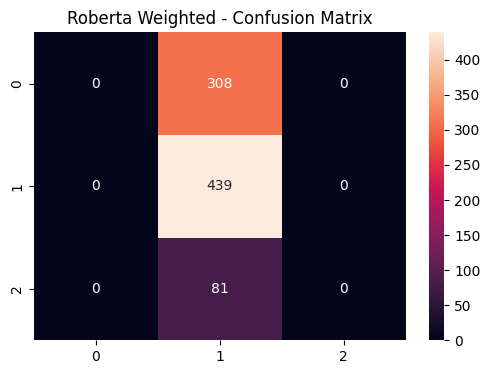

In [20]:
preds = trainer_roberta.predict(test_roberta)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

print(classification_report(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Roberta Weighted - Confusion Matrix")
plt.show()


In [21]:
weighted_roberta = AutoModelForSequenceClassification.from_pretrained(
    roberta_checkpoint,
    num_labels=len(class_counts)
)

trainer_roberta_weight = WeightedTrainer(
    model=weighted_roberta,
    args=args_roberta,
    train_dataset=train_roberta,
    eval_dataset=test_roberta,
    compute_metrics=compute_metrics,
    tokenizer=roberta_tokenizer,
)

trainer_roberta_weight.train()


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1118777776.py:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer_roberta_weight = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,Recall,Precision
1,1.104900,1.087938,0.530193,0.230992,0.333333,0.176731
2,1.104900,1.089657,0.371981,0.180751,0.333333,0.123994
3,1.087400,1.088171,0.371981,0.180751,0.333333,0.123994


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=1242, training_loss=1.097943922555773, metrics={'train_runtime': 435.2668, 'train_samples_per_second': 22.814, 'train_steps_per_second': 2.853, 'total_flos': 653179059509760.0, 'train_loss': 1.097943922555773, 'epoch': 3.0})

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

              precision    recall  f1-score   support

           0       0.37      1.00      0.54       308
           1       0.00      0.00      0.00       439
           2       0.00      0.00      0.00        81

    accuracy                           0.37       828
   macro avg       0.12      0.33      0.18       828
weighted avg       0.14      0.37      0.20       828



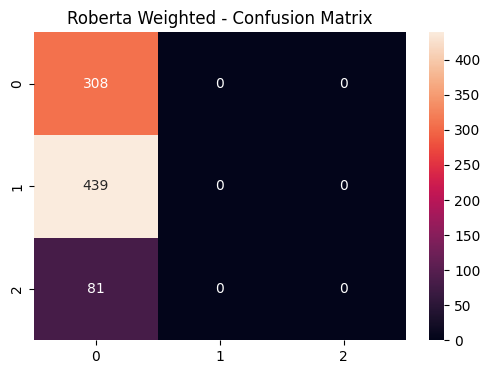

In [22]:
preds = trainer_roberta_weight.predict(test_roberta)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

print(classification_report(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Roberta Weighted - Confusion Matrix")
plt.show()


In [23]:
indo_checkpoint = "indobenchmark/indobert-base-p1"
indo_tokenizer = AutoTokenizer.from_pretrained(indo_checkpoint)
train_indo, test_indo = prepare_dataset(indo_tokenizer, train_df, test_df)

indo_model = AutoModelForSequenceClassification.from_pretrained(
    indo_checkpoint,
    num_labels=len(class_counts)
)

args_indo = TrainingArguments(
    output_dir="./indobert_standard",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=20,
    report_to="none",
    save_total_limit=2
)

trainer_indo = Trainer(
    model=indo_model,
    args=args_indo,
    train_dataset=train_indo,
    eval_dataset=test_indo,
    compute_metrics=compute_metrics,
    tokenizer=indo_tokenizer,
)

trainer_indo.train()


Map:   0%|          | 0/3310 [00:00<?, ? examples/s]

Map:   0%|          | 0/828 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-691494071.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_indo = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,Recall,Precision
1,0.744000,0.712327,0.694444,0.519943,0.511242,0.683826
2,0.577000,0.762287,0.741546,0.642684,0.631563,0.712784
3,0.217700,1.110782,0.740338,0.645802,0.644087,0.647697


TrainOutput(global_step=1242, training_loss=0.4909674121800288, metrics={'train_runtime': 306.4022, 'train_samples_per_second': 32.408, 'train_steps_per_second': 4.053, 'total_flos': 653179059509760.0, 'train_loss': 0.4909674121800288, 'epoch': 3.0})

In [24]:
preds = trainer_indobert.predict(test_indobert)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

print("IndoBERT (No Weight) Classification Report")
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("IndoBERT (No Weight) - Confusion Matrix")
plt.show()


NameError: name 'trainer_indobert' is not defined

In [ ]:
weighted_indo_model = AutoModelForSequenceClassification.from_pretrained(
    indo_checkpoint,
    num_labels=len(class_counts)
)

trainer_indo_weight = WeightedTrainer(
    model=weighted_indo_model,
    args=args_indo,
    train_dataset=train_indo,
    eval_dataset=test_indo,
    compute_metrics=compute_metrics,
    tokenizer=indo_tokenizer,
)

trainer_indo_weight.train()


In [ ]:
preds = trainer_roberta_weight.predict(test_roberta)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

print(classification_report(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Roberta Weighted - Confusion Matrix")
plt.show()


In [ ]:
preds = trainer_indobert_weight.predict(test_indobert)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

print("IndoBERT (Weighted) Classification Report")
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("IndoBERT (Weighted) - Confusion Matrix")
plt.show()


Confusion Matrix

In [ ]:
preds = trainer_roberta_weight.predict(test_roberta)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

print(classification_report(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Roberta Weighted - Confusion Matrix")
plt.show()
